In [1]:
from sklearn import decomposition
from caa.model import ModelWrapper
from caa.utils import load_dataset
import matplotlib.pyplot as plt
import torch as t
from tqdm import tqdm

In [30]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'
device = "cuda:0"
model = ModelWrapper(model_name)
model.setup_layer_activation_hooks()

dataset = load_dataset("refusal_test_ab")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 44.35 GiB total capacity; 43.79 GiB already allocated; 61.38 MiB free; 43.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
def process_activations(activations): return t.stack(
        [activation.to('cpu')[:, -1] for name, activation in activations], dim=1)

all_activations_p = []
all_activations_n = []

# TODO: we probably want to batch this as some of the datasets are large
for data in tqdm(dataset):
    input_p = model.tokenize_question(
        data['question'], data['answer_matching_behavior'][:2]).to("cuda:0")
    
    input_n = model.tokenize_question(
        data['question'], data['answer_not_matching_behavior'][:2]).to("cuda:0")

    model(input_p)
    activations_p = model.get_last_layer_activations()
    all_activations_p.append(process_activations(activations_p))

    model(input_n)
    activations_n = model.get_last_layer_activations()
    all_activations_n.append(process_activations(activations_n))

# stack all tensors and flatten batch and question dimensions
activations_p_tensor = t.stack(all_activations_p, dim=0).flatten(0, 1)
activations_n_tensor = t.stack(all_activations_n, dim=0).flatten(0, 1)

100%|██████████| 458/458 [01:53<00:00,  4.04it/s]


In [34]:
model.get_last_activations().items()

dict_items([('model.layers.0', tensor([[[-0.0116,  0.0113,  0.0560,  ..., -0.0172, -0.0543,  0.0397],
         [ 0.0565, -0.0082,  0.0087,  ...,  0.0280, -0.0240, -0.0087],
         [-0.0275, -0.0091, -0.0799,  ...,  0.0336,  0.0081, -0.0680],
         ...,
         [-0.0557, -0.0268,  0.0150,  ...,  0.0226, -0.0022,  0.0128],
         [ 0.0133,  0.0035, -0.0213,  ...,  0.0057, -0.0065, -0.0084],
         [ 0.0023, -0.0353, -0.0092,  ..., -0.0005, -0.0075, -0.0052]]],
       device='cuda:0')), ('model.layers.1', tensor([[[ 0.0699, -0.5114,  0.0642,  ...,  0.2500, -0.0598, -0.0261],
         [ 0.0394, -0.0271,  0.0127,  ...,  0.0591,  0.0341,  0.0065],
         [-0.1184, -0.0272, -0.1200,  ...,  0.0717,  0.0230, -0.1053],
         ...,
         [-0.0712, -0.0195, -0.0009,  ...,  0.0065, -0.0080,  0.0097],
         [ 0.0090,  0.0253, -0.0496,  ..., -0.0102, -0.0009, -0.0297],
         [ 0.0085, -0.0187, -0.0311,  ...,  0.0127,  0.0117, -0.0022]]],
       device='cuda:0')), ('model.layers

In [26]:
layer_9_activ_pos = activations_p_tensor[:, 9]
layer_10_activ_pos = activations_p_tensor[:, 10]

layer_9_activ_neg = activations_n_tensor[:, 9]
layer_10_activ_neg = activations_n_tensor[:, 10]


In [28]:
pca = decomposition.PCA(n_components=2)
X_layer_9_pos = pca.fit_transform(layer_9_activ_pos.numpy())
X_layer_9_neg = pca.fit_transform(layer_9_activ_neg.numpy())

X_layer_10_pos = pca.fit_transform(layer_10_activ_pos.numpy())
X_layer_10_neg = pca.fit_transform(layer_10_activ_neg.numpy())

X_layer_9_pos.shape

(458, 2)

/tmp/ipykernel_25093/3476129199.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_layer_9_neg[:, 0], X_layer_9_neg[:, 1], cmap="red")
/tmp/ipykernel_25093/3476129199.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_layer_10_pos[:, 0], X_layer_10_pos[:, 1], cmap="green")
/tmp/ipykernel_25093/3476129199.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_layer_10_neg[:, 0], X_layer_10_neg[:, 1], cmap="yellow")


[]

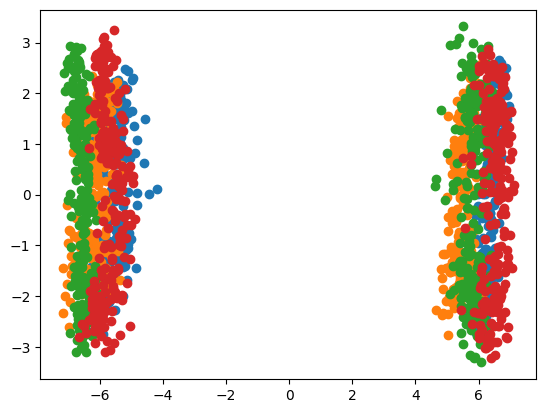

In [31]:
plt.clf()
plt.scatter(X_layer_9_pos[:, 0], X_layer_9_pos[:, 1])
plt.scatter(X_layer_9_neg[:, 0], X_layer_9_neg[:, 1], cmap="red")
plt.scatter(X_layer_10_pos[:, 0], X_layer_10_pos[:, 1], cmap="green")
plt.scatter(X_layer_10_neg[:, 0], X_layer_10_neg[:, 1], cmap="yellow")

plt.plot()